In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import random
import math
import torch
import cv2
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from collections import namedtuple
Circle = namedtuple('Circle', ['x', 'y', 'r', 'O', 'c'])
Rectangle = namedtuple('Rectangle', ['x', 'y', 'k', 'a', 'b', 'O', 'c'])
# x & y : any float (location of center of the obstacle)
# r: radius of circle
# k: angle of the rectangle (0 to pi/2)
# a, b: sides of the rectangle
# O, c: opacity and color of the obstacle

# color_map, polar_map -> uint8 array
# opacity_map -> bool array

class Terrain:
    def __init__(self, map_size, initial_location = None):
        self.map_size = map_size
        self.color_map = torch.zeros([map_size, map_size], device = device);
        self.Y,self.X = torch.meshgrid(torch.linspace(1, self.map_size ,self.map_size, device = device), torch.linspace(1, self.map_size ,self.map_size, device = device))
        self.n_circles = 5
        self.n_rectangles = 5
    def initialize_terrain(self):
        self.color_map = torch.zeros([self.map_size, self.map_size], device = device);
        A = [Circle(x = random.randrange(0, self.map_size), 
                    y = random.randrange(0, self.map_size), 
                    r = random.randrange(0, int(self.map_size/2)), 
                    O = bool(random.getrandbits(1)), 
                    c = random.random()) for i in range(self.n_circles)]
        A += [Rectangle(x = random.randrange(0, self.map_size), 
                        y = random.randrange(0, self.map_size), 
                        k = random.uniform(0, math.pi/2), 
                        a = random.uniform(0, self.map_size/2), 
                        b = random.uniform(0, self.map_size/2), 
                        O = bool(random.getrandbits(1)), 
                        c = random.random()) for j in range(self.n_rectangles)]
        self.generate_terrain(A)
    def generate_terrain(self, A):
        for i in A:
            if type(i).__name__ == 'Circle':
                mask = self.circular_obstacle(i)
            elif type(i).__name__ == 'Rectangle':
                mask = self.rectangular_obstacle(i)
            if i.O:
                self.color_map = self.color_map*(~mask)+(i.c*mask)
            else:
                self.color_map = self.color_map*(~mask)
    def circular_obstacle(self, i):
        return (self.X-i.x)**2 + (self.Y-i.y)**2 <= i.r**2
    def rectangular_obstacle(self, i):
        return  torch.logical_and((torch.abs((self.X-i.x)/(math.cos(i.k)+0.001)-(self.Y-i.y)/(math.sin(i.k)+0.001)))<=(i.a*abs(math.tan(i.k)+1/(math.tan(i.k)+0.001))/2),
                               (torch.abs((self.X-i.x)/(math.sin(i.k)+0.001)+(self.Y-i.y)/(math.cos(i.k)+0.001)))<=(i.b*abs(math.tan(i.k)+1/(math.tan(i.k)+0.001))/2))



/home/audrud/mambaforge/envs/torch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


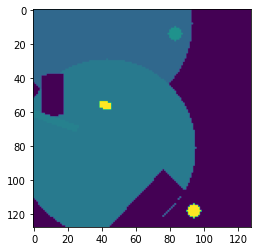

In [3]:
a = Terrain(128)
A = [Rectangle(x = 50, y = 40, k = 0.5, a = 40, b = 40, O = True, c = 80),
     Rectangle(x = 80, y = 20, k = 0.0, a = 40, b = 40, O = False, c = 28),
     Rectangle(x = 180, y = 90, k = 0.8, a = 100, b = 10, O = True, c = 50),
     Circle(x = 130, y = 230, r = 80, O = True, c = 30),
     Circle(x = 100, y = 90, r = 40, O = True, c = 200),
     Circle(x = 30, y = 130, r = 20, O = True, c = 50),]
a.initialize_terrain()
#a.generate_terrain(A)
plt.imshow(a.color_map.T.to('cpu'))


In [4]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


torch.Size([1, 1, 64, 64])


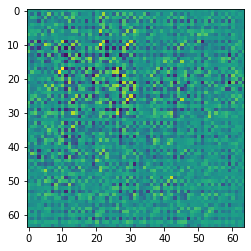

In [5]:
class Simple_AE(nn.Module):
    def __init__(self, map_size):
        super().__init__()
        self.map_size = map_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            BasicBlock(16, 16, stride = 1),
            BasicBlock(16, 16, stride = 1),
            BasicBlock(16, 32, stride = 2),
            BasicBlock(32, 32, stride = 1),
            BasicBlock(32, 32, stride = 1),
            BasicBlock(32, 64, stride = 2),
            BasicBlock(64, 64, stride = 1),
            BasicBlock(64, 64, stride = 2),
            BasicBlock(64, 64, stride = 1),
            BasicBlock(64, 64, stride = 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride = 2, padding = 1, output_padding = 1),
            #nn.ReLU(),
            #nn.Upsample(scale_factor = 2),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        return x

M = Simple_AE(64).to(device)
output = M(torch.ones([1, 1, 64, 64], device = device))
print(output.shape)
plt.imshow(output.to('cpu').reshape(64,64).detach().numpy())




In [6]:
class Trans_AE(nn.Module):
    def __init__(self, map_size, device = device):
        super().__init__()
        # Resnet block based image encoder
        self.device = device
        self.map_size = map_size
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 16, 7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            BasicBlock(16, 16, stride = 1),
            BasicBlock(16, 16, stride = 1),
            BasicBlock(16, 16, stride = 1),
            BasicBlock(16, 32, stride = 2),
            BasicBlock(32, 32, stride = 1),
            BasicBlock(32, 32, stride = 1),
            BasicBlock(32, 32, stride = 1),
            BasicBlock(32, 64, stride = 2),
            BasicBlock(64, 64, stride = 1),
            BasicBlock(64, 64, stride = 1),
            BasicBlock(64, 64, stride = 1),
            nn.Flatten(),
        ).to(self.device)
        self.decoder = nn.Sequential(
            nn.Linear(4098, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        ).to(self.device)

    def point_to_pixel(self, encode, points):
        x = torch.cat([points, encode.unsqueeze(1).repeat(1,points.shape[1],1)], dim=2)
        pixel = self.decoder(x)
        return pixel.reshape(x.shape[0], points.shape[1])

    def forward(self, x):
        x = self.cnn_backbone(x)
        return x

    def criterion(self, x, n_points):
        points = torch.randint(0, self.map_size, (x.shape[0], n_points, 2), device=self.device)
        enc = self.forward(x)
        colors = self.point_to_pixel(enc, points)
        batch_ind = torch.arange(0, x.shape[0], device=self.device).unsqueeze(1).repeat(1, n_points)
        x_ind = points[:,:,0]
        y_ind = points[:,:,1]
        original = x[batch_ind, 0, x_ind, y_ind]
        return torch.mean((colors - original)**2)

M = Trans_AE(64, device = device)
output = M.criterion(torch.ones([64, 1, 64, 64], device = device), 512)
print(output)


tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)


In [9]:
batch_size = 64
epoch = 100000
learning_rate = 0.001
t = Terrain(64)
Model = Simple_AE(64).to(device)
optimizer = torch.optim.Adam(Model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()


0.23580170467495917


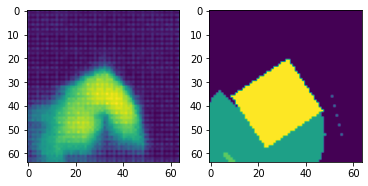

0.06019332366995513


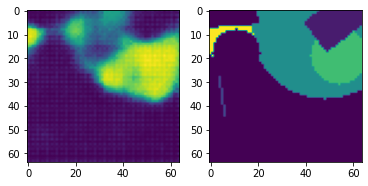

0.0464311761688441


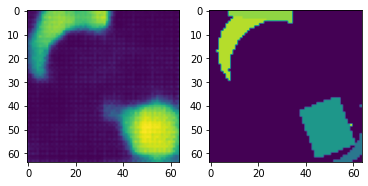

KeyboardInterrupt: 

In [10]:
l_sum = 0
batch = torch.zeros([batch_size, 1, t.map_size, t.map_size], device = device)


for i in range(epoch):
    for j in range(batch_size):
        t.initialize_terrain()
        batch[j] = t.color_map
    optimizer.zero_grad()
    loss = criterion(Model(batch), batch)
    loss.backward()
    optimizer.step()
    l_sum += loss.item()
    
    if i%400 == 0 and i != 0:
        val_input = torch.zeros([1, 1, t.map_size, t.map_size], device = device)
        t.initialize_terrain()
        val_input[0] = t.color_map
        val_output = Model(val_input)
        print(l_sum / 100)
        plt.subplot(1,2,1)
        plt.imshow(val_output.to('cpu').reshape(t.map_size,t.map_size).detach().numpy())
        plt.subplot(1,2,2)
        plt.imshow(val_input.to('cpu').reshape(t.map_size,t.map_size).detach().numpy())
        plt.show()
        l_sum = 0
    
    


In [11]:
batch_size = 64
epoch = 100000
learning_rate = 0.001
t = Terrain(64)
Model = Trans_AE(64).to(device)
optimizer = torch.optim.Adam(Model.parameters(), lr = learning_rate)
criterion = Model.criterion
n_points = 512

In [12]:
l_sum = 0
batch = torch.zeros([batch_size, 1, t.map_size, t.map_size], device = device)


for i in range(epoch):
    for j in range(batch_size):
        t.initialize_terrain()
        batch[j] = t.color_map
    optimizer.zero_grad()
    loss = criterion(batch, n_points)
    loss.backward()
    optimizer.step()
    l_sum += loss.item()
    
    if i%400 == 0 and i != 0:
        print(l_sum / 100)
        l_sum = 0

In [ ]:
batch = torch.zeros([1, 1, t.map_size, t.map_size], device = device)
t.initialize_terrain()
batch[0] = t.color_map
mesh = torch.zeros([1, 64*64, 2], device = device)
for i in range(64):
    for j in range(64):
        mesh[0, i*64+j, 0] = i
        mesh[0, i*64+j, 1] = j
output = Model.point_to_pixel(Model.forward(batch), mesh)
output = output.reshape(64, 64)
plt.subplot(1,2,1)
plt.imshow(output.to('cpu').detach().numpy())
plt.subplot(1,2,2)
plt.imshow(t.color_map.to('cpu').detach().numpy())
plt.show()
39/40:
l_sum = 0
batch = torch.zeros([batch_size, 1, t.map_size, t.map_size], device = device)


for i in range(epoch):
    for j in range(batch_size):
        t.initialize_terrain()
        batch[j] = t.color_map
    optimizer.zero_grad()
    loss = criterion(batch, n_points)
    loss.backward()
    optimizer.step()
    l_sum += loss.item()
    
    if i%400 == 0 and i != 0:
        print(l_sum / 100)
        l_sum = 0